In [1]:
from pydataset import data

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import wrangle as w
import evaluate as ev
import model as m

import warnings
warnings.filterwarnings('ignore')

# Exercises
### Do your work for this exercise in a jupyter notebook named modeling within the regression-exercises repo. Add, commit, and push your work.

## 1.Select a dataset with a continuous target variable.
- I decided to use PearsonLee dataset from pydata. 
- Each row is a child
- Each column is an attribute of the child (parent's height, ...)
    - I'm not sure what frequency is, but I'll leave it in
- the target is the height of the child ('child')


## 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

## 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.


In [2]:
df = data('PearsonLee')

In [3]:
data('PearsonLee', show_doc=True)

PearsonLee

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

##  Pearson and Lee's data on the heights of parents and children classified
by gender

### Description

Wachsmuth et. al (2003) noticed that a loess smooth through Galton's data on
heights of mid-parents and their offspring exhibited a slightly non-linear
trend, and asked whether this might be due to Galton having pooled the heights
of fathers and mothers and sons and daughters in constructing his tables and
graphs.

To answer this question, they used analogous data from English families at
about the same time, tabulated by Karl Pearson and Alice Lee (1896, 1903), but
where the heights of parents and children were each classified by gender of
the parent.

### Usage

    data(PearsonLee)

### Format

A frequency data frame with 746 observations on the following 6 variables.

`child`

child height in inches, a numeric vector

`parent`

parent height in inches, a numeric vector

`frequenc

In [4]:
df.sample(5)

,child,parent,frequency,gp,par,chl
209,59.5,57.5,3.50,md,Mother,Daughter
260,62.5,63.5,24.00,md,Mother,Daughter
98,68.5,70.5,10.00,fs,Father,Son
149,73.5,62.5,1.00,fs,Father,Son
396,64.5,60.5,7.75,ms,Mother,Son


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 1 to 746
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   child      746 non-null    float64
 1   parent     746 non-null    float64
 2   frequency  746 non-null    float64
 3   gp         746 non-null    object 
 4   par        746 non-null    object 
 5   chl        746 non-null    object 
dtypes: float64(3), object(3)
memory usage: 40.8+ KB


In [6]:
df.describe()

,child,parent,frequency
count,746.000000,746.000000,746.000000
mean,66.048257,65.012466,6.557641
std,5.141327,4.749046,8.633186
min,52.500000,52.500000,0.250000
25%,62.500000,61.500000,0.750000
50%,65.500000,65.500000,2.500000
75%,69.500000,68.500000,9.250000
max,79.500000,75.500000,46.500000


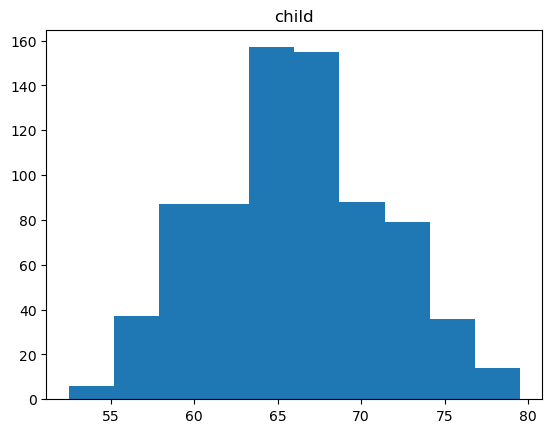

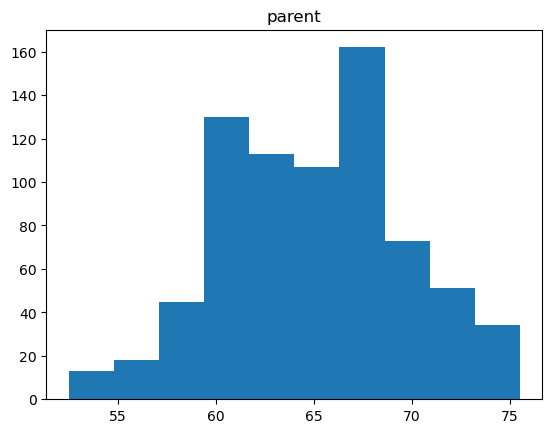

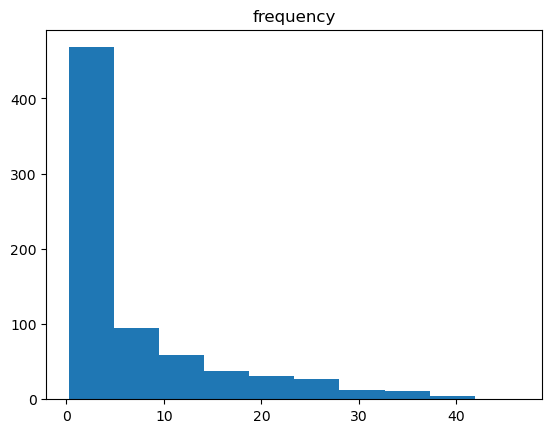

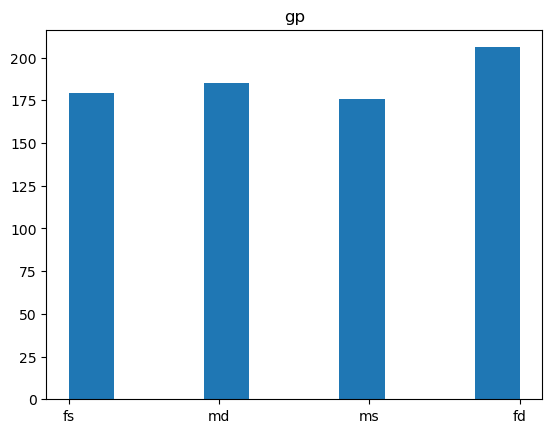

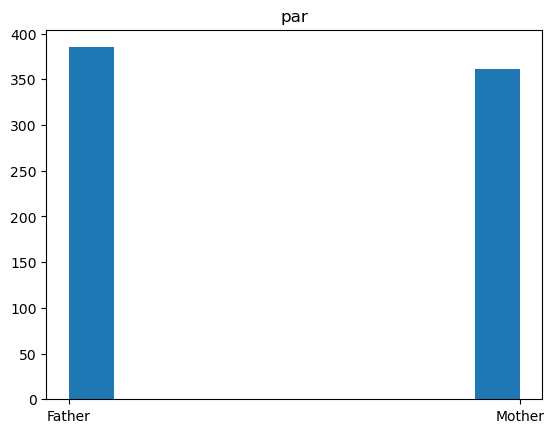

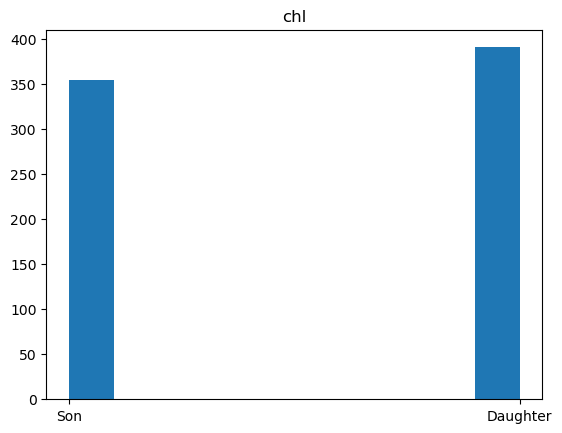

In [7]:
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [8]:
# still need to encode categorical columns. Will do after exploring train
train, validate, test = w.split_function(df)

Prepared df: (746, 6)

Train: (447, 6)
Validate: (149, 6)
Test: (150, 6)


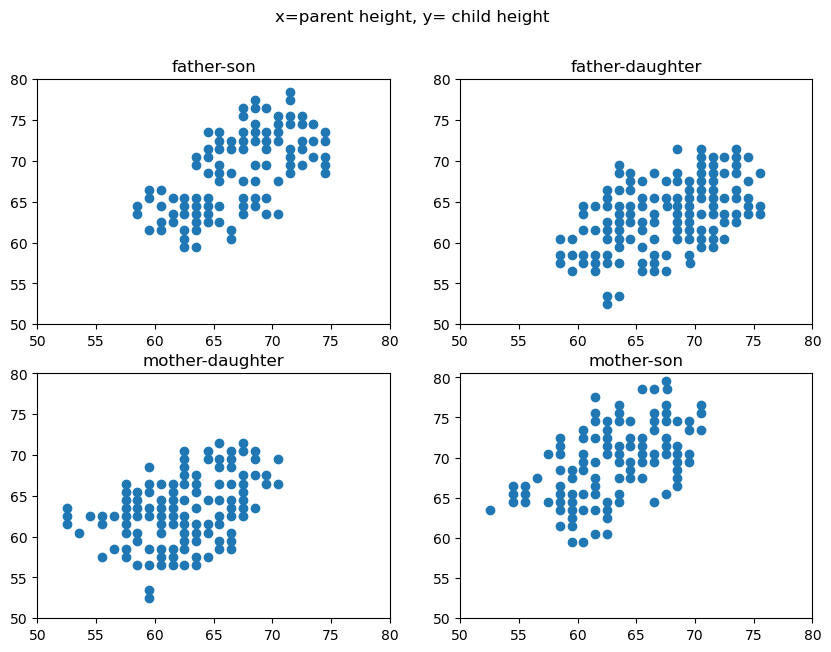

In [9]:
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.scatter(train[train.gp == 'fs'].parent, train[train.gp == 'fs'].child)
plt.title('father-son')
plt.xticks(np.arange(50,85,5))
plt.yticks(np.arange(50,85,5))

plt.subplot(2,2,2)
plt.scatter(train[train.gp == 'fd'].parent, train[train.gp == 'fd'].child)
plt.title('father-daughter')
plt.xticks(np.arange(50,85,5))
plt.yticks(np.arange(50,85,5))

plt.subplot(2,2,3)
plt.scatter(train[train.gp == 'md'].parent, train[train.gp == 'md'].child)
plt.title('mother-daughter')
plt.xticks(np.arange(50,85,5))
plt.yticks(np.arange(50,85,5))

plt.subplot(2,2,4)
plt.scatter(train[train.gp == 'ms'].parent, train[train.gp == 'ms'].child)
plt.title('mother-son')
plt.xticks(np.arange(50,85,5))
plt.yticks(np.arange(50,85,5))

plt.suptitle('x=parent height, y= child height')

plt.show()

### The parent's height matters. So does the gender of the child and the parent.

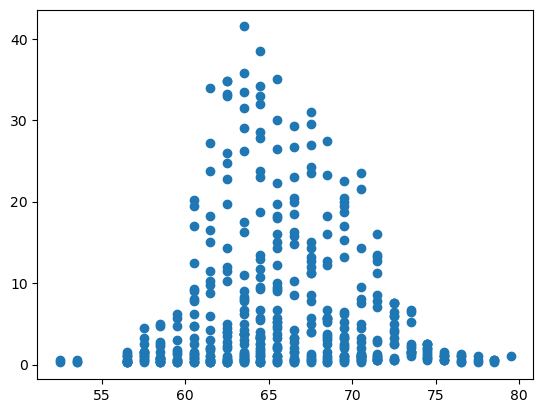

In [10]:
plt.scatter(train.child, train.frequency)
plt.show()

### Ok, so the frequency is a measure of how often (in perhaps some larger dataset) a particular combination of child, parent, gp occur

### Hypothesis
- Is frequency associated with child (height)?
- $H_0$ There is NO relationship between frequency and child
- $H_a$ There IS a relationship
- $\alpha$ = .05
- continuous vs continuous = pearson

In [11]:
import scipy.stats as stats

In [12]:
t, p = stats.pearsonr(train.child, train.frequency)
t, p

(-0.046225905543996505, 0.32950559684381475)

### Since p is > .05 (alpha), we cannot reject the H0
- So I will not include the frequency column. It kind of makes sense. If there was a row that was repeated over and over, i.e. a high frequency, would that affect the model?  For LinearRegression, I would say not. For something else, I'm not sure.

## Modeling Prep

In [13]:
# time to make the encoded columns. 
# scaling is not required since the only other continuous variable (parent) is on the same scale as child

In [14]:
# starting over with data gathering
df = data('PearsonLee')

In [15]:
# dropping 'frequency' per exploration and 'gp' because it is simply a combination of par and chl
df = df.drop(columns=['frequency', 'gp'])

In [16]:
scaled_df = pd.get_dummies(data=df, columns=['par', 'chl'], drop_first=True)
scaled_df.head()

,child,parent,par_Mother,chl_Son
1,59.5,62.5,0,1
2,59.5,63.5,0,1
3,59.5,64.5,0,1
4,60.5,62.5,0,1
5,60.5,66.5,0,1


In [17]:
# split data
train, validate, test = w.split_function(scaled_df)

Prepared df: (746, 4)

Train: (447, 4)
Validate: (149, 4)
Test: (150, 4)


In [18]:
X_train = train[['parent', 'par_Mother', 'chl_Son']]
y_train = train.child
X_validate = validate[['parent', 'par_Mother', 'chl_Son']]
y_validate = validate.child
X_test = test[['parent', 'par_Mother', 'chl_Son']]
y_test = test.child

## Plot target variable

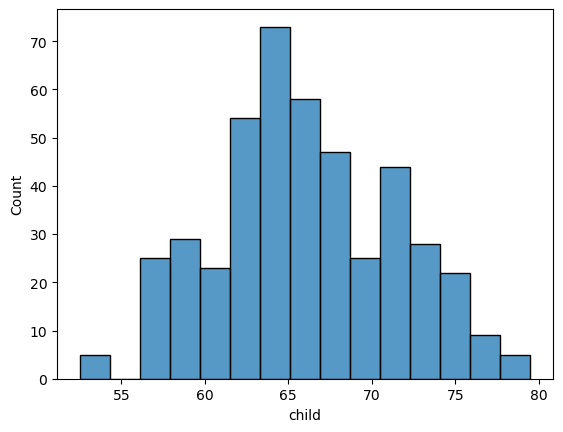

In [19]:
sns.histplot(y_train)
plt.show()

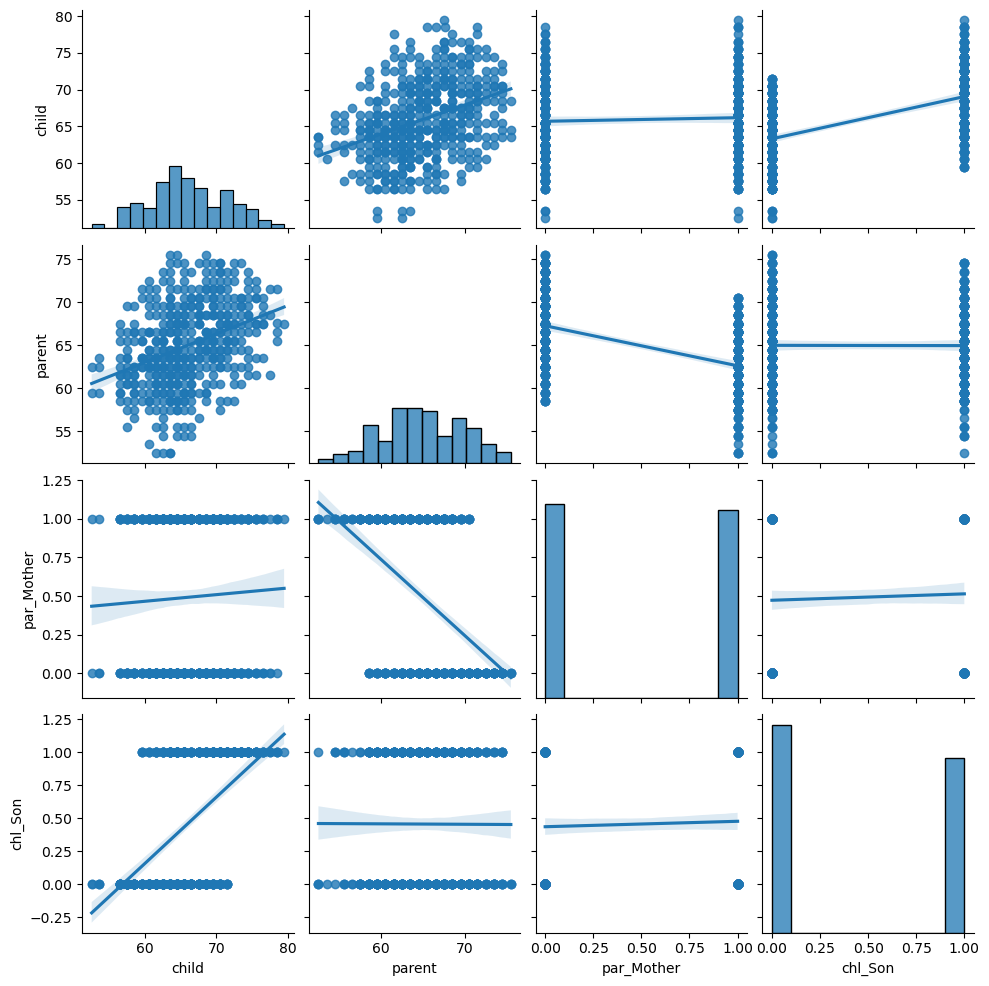

In [20]:
sns.pairplot(data=train, kind='reg')
plt.show()

### Establish baseline

In [21]:
# copying function from Misty to help get metrics for comparing models
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [22]:
def get_baseline_train_val_metrics(y_train, y_validate):
    """
    This function will
    - accept y_train and y_validate
    - calculate a baseline which is the mean of y_train
    - return RMSE and R^2 scores for train and validate
    """
    y_train_baseline = np.repeat(y_train.mean(), len(y_train))
    y_val_baseline = np.repeat(y_train.mean(), len(y_validate))
    
    RMSE_train, R2_train = metrics_reg(y_train, y_train_baseline)
    RMSE_val, R2_val = metrics_reg(y_validate, y_val_baseline)
    
    return RMSE_train, R2_train, RMSE_val, R2_val

In [23]:
# get eval metrics/scores for baseline
RMSE_train, R2_train, RMSE_val, R2_val = m.get_baseline_train_val_metrics(y_train, y_validate)
RMSE_train, R2_train, RMSE_val, R2_val

(5.333872883838122, 0.0, 4.726446765866954, -0.009318277200712988)

In [24]:
#initialize dataframe with results
results_df = pd.DataFrame( data=[{'model':'baseline', 
                                  'RMSE_train': RMSE_train, 
                                  'R^2_train': R2_train,
                                  'RMSE_validate': RMSE_val,
                                  'R^2_validate': R2_val}])
results_df

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,5.333873,0.0,4.726447,-0.009318


### Ordinary Least Squares

In [25]:
def get_ols_train_val_metrics(X_train, y_train, X_val, y_val):
    """
    This function will 
    - accept X_train, y_train, X_val, y_val)
    - it will build an OLS model on whatever was sent in X_train
        - note same number of columns should be in X_train and X_val
    - it will fit the model on X_train
    - it will make predictions and return RMSE and R^2 scores for the predictions for train and val
    - returns RMSE_train, R2_train, RMSE_val, R2_val
    """
    
    # make the thing
    lr = LinearRegression()
    
    # fit the thing
    lr.fit(X_train, y_train)
    
    # use the thing
    y_pred_train = lr.predict(X_train)
    y_pred_val = lr.predict(X_val)
    
    RMSE_train, R2_train = metrics_reg(y_train, y_pred_train)
    RMSE_val, R2_val = metrics_reg(y_val, y_pred_val)
    
    return RMSE_train, R2_train, RMSE_val, R2_val

#### simple linear regression + RFE
- send in only one feature

In [26]:
# initialize ML model
lr1 = LinearRegression()

# make it (RFE)
rfe = RFE(lr1, n_features_to_select=1)

# fit it
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [27]:
# take a look; weird that chl_son is the best feature
rfe.get_feature_names_out()

array(['chl_Son'], dtype=object)

In [28]:
# use the rfe helper to select just the column(s) that rfe told us were the best
X_train_rfe = rfe.transform(X_train)
X_validate_rfe = rfe.transform(X_validate)

### build model from top feature

In [29]:
# fit the thing (linear regression model on the column(s) from rfe)
lr1.fit(X_train_rfe, y_train)

# use the thing to make predictions
y_pred_lr1 = lr1.predict(X_train_rfe)
y_pred_val_lr1 = lr1.predict(X_validate_rfe)
y_pred_lr1[:5]

array([69.04901961, 63.30246914, 63.30246914, 63.30246914, 69.04901961])

In [30]:
# only two unique values, as expected when the feature we sent in was a 0 or a 1

#### evaluate

In [31]:
# get metrics for just sending in the top feature we got from rfe ('chl_Son')
RMSE_train, R2_train, RMSE_val, R2_val= m.get_ols_train_val_metrics(X_train_rfe, 
                                                                  y_train, 
                                                                  X_validate_rfe, 
                                                                  y_validate)
RMSE_train, R2_train, RMSE_val, R2_val

(4.500814821193581, 0.2879721725427026, 4.414930281708642, 0.11934400516200072)

In [32]:
# not over fit! 
# add to results_df
results_df.loc[1] = ['ols1', RMSE_train, R2_train, RMSE_val, R2_val]
results_df

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,5.333873,0.000000,4.726447,-0.009318
1,ols1,4.500815,0.287972,4.414930,0.119344


## Multiple Regression
- model using OLS

In [33]:
# make it (no need to mess with rfe this time; sending in all features)
lr2 = LinearRegression()

# fit the thing
lr2.fit(X_train, y_train)

# use the thing
y_pred = lr2.predict(X_train)
y_pred_val = lr2.predict(X_validate)

In [34]:
y_pred[:5]

array([68.00318157, 61.22263969, 60.69034527, 63.95017104, 68.53547599])

#### evaluate

In [35]:
# make it (no need to mess with rfe this time; sending in all features)
RMSE_train, R2_train, RMSE_val, R2_val = m.get_ols_train_val_metrics(X_train, 
                                                                   y_train, 
                                                                   X_validate, 
                                                                   y_validate)
RMSE_train, R2_train, RMSE_val, R2_val

(3.8843412643661774,
 0.4696660449003013,
 3.9288137574617537,
 0.3026007436591097)

In [36]:
# not bad
results_df.loc[2] = ['ols-all', RMSE_train, R2_train, RMSE_val, R2_val]
results_df

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,5.333873,0.000000,4.726447,-0.009318
1,ols1,4.500815,0.287972,4.414930,0.119344
2,ols-all,3.884341,0.469666,3.928814,0.302601


In [37]:
# curious if parent is really a worse predictor than chl_Son
RMSE_train, R2_train, RMSE_val, R2_val = m.get_ols_train_val_metrics(X_train[['parent']], 
                                                                   y_train, 
                                                                   X_validate[['parent']], 
                                                                   y_validate)
RMSE_train, R2_train, RMSE_val, R2_val

(4.974668875726114,
 0.13015267117671692,
 4.4256135286284755,
 0.11507682633826832)

In [38]:
# yep. parent is really a worse predictor that chl_Son
results_df.loc[3] = ['ols-parent', RMSE_train, R2_train, RMSE_val, R2_val]
results_df

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,5.333873,0.000000,4.726447,-0.009318
1,ols1,4.500815,0.287972,4.414930,0.119344
2,ols-all,3.884341,0.469666,3.928814,0.302601
3,ols-parent,4.974669,0.130153,4.425614,0.115077


## LassoLars

In [39]:
def get_lassolars_train_val_metrics(X_train, y_train, X_val, y_val, alpha=1):
    """
    This function will 
    - accept X_train, y_train, X_val, y_val)
    - it will build a LassoLars model on whatever was sent in X_train (alpha=1 default)
        - note same number of columns should be in X_train and X_val
    - it will fit the model on X_train
    - it will make predictions and return RMSE and R^2 scores for the predictions for train and val
    - returns RMSE_train, R2_train, RMSE_val, R2_val
    """
    
    # make the thing
    lasso = LassoLars(alpha=alpha)
    
    # fit the thing
    lasso.fit(X_train, y_train)
    
    # print coefficients (during test)
#     print(pd.Series(lasso.coef_, index=lasso.feature_names_in_))
    
    # use the thing
    y_pred_train = lasso.predict(X_train)
    y_pred_val = lasso.predict(X_val)
    
    RMSE_train, R2_train = metrics_reg(y_train, y_pred_train)
    RMSE_val, R2_val = metrics_reg(y_val, y_pred_val)
    
    return RMSE_train, R2_train, RMSE_val, R2_val

In [40]:
RMSE_train, R2_train, RMSE_val, R2_val = m.get_lassolars_train_val_metrics(X_train, 
                                                                         y_train, 
                                                                         X_validate, 
                                                                         y_validate)
RMSE_train, R2_train, RMSE_val, R2_val

(5.333872883838122, 0.0, 4.726446765866954, -0.009318277200712988)

In [41]:
#LassoLars was not very good.
results_df.loc[4] = ['LassoLars', RMSE_train, R2_train, RMSE_val, R2_val]
results_df

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,5.333873,0.000000,4.726447,-0.009318
1,ols1,4.500815,0.287972,4.414930,0.119344
2,ols-all,3.884341,0.469666,3.928814,0.302601
3,ols-parent,4.974669,0.130153,4.425614,0.115077
4,LassoLars,5.333873,0.000000,4.726447,-0.009318


## Polynomial Regression
### Create new features based on degrees

In [42]:
# make the "thing" so I can get new polynomial features to send in to a different thing
pf = PolynomialFeatures(degree=2)

#fit the thing
pf.fit(X_train)

# use the thing to make new feature values
X_train_degree2 = pf.transform(X_train)
X_validate_degree2 = pf.transform(X_validate)

### fit on a linear regression model

In [43]:
# make it
pr = LinearRegression()

# fit it
pr.fit(X_train_degree2, y_train)

# use it
y_pred_pr = pr.predict(X_train_degree2)
y_val_pred_pr = pr.predict(X_validate_degree2)

#### evaluate

In [44]:
metrics_reg(y_train, y_pred_pr)

(3.849761418881005, 0.4790664735900223)

In [45]:
# rmse, r2 = metrics_reg(y_validate, y_val_pred_pr)

In [46]:
# results_df.loc[5] = ['Polynomial Reg', rmse, r2]

In [47]:
def get_polynomial_train_val_metrics(X_train, y_train, X_val, y_val, degrees=2):
    """
    This function will 
    - accept X_train, y_train, X_val, y_val)
    - it will build polynomial features with degrees=2 default value, then test on a LinearRegression model
        - note same number of columns should be in X_train and X_val
    - it will fit the model on X_train
    - it will make predictions and return RMSE and R^2 scores for the predictions for train and val
    - returns RMSE_train, R2_train, RMSE_val, R2_val
    """
    
    # make the "thing" so I can get new polynomial features to send in to a different thing
    pf = PolynomialFeatures(degree=2)

    #fit the thing
    pf.fit(X_train)

    # use the thing to make new feature values
    X_train_degree2 = pf.transform(X_train)
    X_validate_degree2 = pf.transform(X_validate)

    # make it
    pr = LinearRegression()

    # fit it
    pr.fit(X_train_degree2, y_train)

    # use it
    y_pred_train = pr.predict(X_train_degree2)
    y_pred_val = pr.predict(X_validate_degree2)
    
    RMSE_train, R2_train = metrics_reg(y_train, y_pred_train)
    RMSE_val, R2_val = metrics_reg(y_val, y_pred_val)
    
    return RMSE_train, R2_train, RMSE_val, R2_val

In [48]:
RMSE_train, R2_train, RMSE_val, R2_val= m.get_polynomial_train_val_metrics(X_train, 
                                                                         y_train, 
                                                                         X_validate, 
                                                                         y_validate)

In [49]:
results_df.loc[5] = ['Polynomial Regression', RMSE_train, R2_train, RMSE_val, R2_val]
results_df

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,5.333873,0.000000,4.726447,-0.009318
1,ols1,4.500815,0.287972,4.414930,0.119344
2,ols-all,3.884341,0.469666,3.928814,0.302601
3,ols-parent,4.974669,0.130153,4.425614,0.115077
4,LassoLars,5.333873,0.000000,4.726447,-0.009318
5,Polynomial Regression,3.849761,0.479066,3.971438,0.287386


## Generalized Linear Model (GLM)


### The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

- About power:

    - power = 0: Normal Distribution
    - power = 1: Poisson Distribution
    - power = (1,2): Compound Distribution
    - power = 2: Gamma Distribution
    - power = 3: Inverse Gaussian Distribution

In [50]:
# make it
glm = TweedieRegressor(power=0, alpha=0)

# fit it
glm.fit(X_train, y_train)

# use it
y_pred = glm.predict(X_train)
y_pred_val = glm.predict(X_validate)

### evaluate

In [51]:
metrics_reg(y_train, y_pred)

(3.884341264557253, 0.4696660448481257)

In [52]:
rmse, r2 = metrics_reg(y_validate, y_pred_val)
rmse, r2

(3.9288119607117524, 0.3026013815370574)

In [53]:
def get_glm_train_val_metrics(X_train, y_train, X_val, y_val, power=0, alpha=0):
    """
    This function will 
    - accept X_train, y_train, X_val, y_val)
    - it will build Generalized Linea Model power=0, alpha=0 default value
        - note same number of columns should be in X_train and X_val
    - it will fit the model on X_train
    - it will make predictions and return RMSE and R^2 scores for the predictions for train and val
    - returns RMSE_train, R2_train, RMSE_val, R2_val
    """
    
    # make it
    glm = TweedieRegressor(power=power, alpha=alpha)

    # fit it
    glm.fit(X_train, y_train)

    # use it
    y_pred_train = glm.predict(X_train)
    y_pred_val = glm.predict(X_validate)
    
    RMSE_train, R2_train = metrics_reg(y_train, y_pred_train)
    RMSE_val, R2_val = metrics_reg(y_val, y_pred_val)
    
    return RMSE_train, R2_train, RMSE_val, R2_val

In [54]:
RMSE_train, R2_train, RMSE_val, R2_val = m.get_glm_train_val_metrics(X_train, 
                                                                   y_train, 
                                                                   X_validate, 
                                                                   y_validate, power=2)
RMSE_train, R2_train, RMSE_val, R2_val

(3.8733392748406703,
 0.4726660210063305,
 3.924679239815689,
 0.30406779835826536)

In [55]:
results_df.loc[6] = ['GLM', RMSE_train, R2_train, RMSE_val, R2_val]
results_df

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,5.333873,0.000000,4.726447,-0.009318
1,ols1,4.500815,0.287972,4.414930,0.119344
2,ols-all,3.884341,0.469666,3.928814,0.302601
3,ols-parent,4.974669,0.130153,4.425614,0.115077
4,LassoLars,5.333873,0.000000,4.726447,-0.009318
5,Polynomial Regression,3.849761,0.479066,3.971438,0.287386
6,GLM,3.873339,0.472666,3.924679,0.304068


## GLM with power = 2 (Gamma) has the best prediction on val

### Moment of truth, I will make/fit/use GLM with power = 2 and evaluate on test

In [56]:
glm = TweedieRegressor(power = 2, alpha=0)
glm.fit(X_train, y_train)

TweedieRegressor(alpha=0, power=2)

In [57]:
y_pred_test = glm.predict(X_test)

In [58]:
metrics_reg(y_test, y_pred_test)

(4.0506673520339325, 0.326509451818906)

In [62]:
RMSE_train, R2_train, RMSE_test, R2_test = m.get_glm_train_val_metrics(X_train, 
                                                                   y_train, 
                                                                   X_test, 
                                                                   y_test, power=2)
RMSE_train, R2_train, RMSE_test, R2_test

(3.8733392748406703, 0.4726660210063305, 4.0506673520339325, 0.326509451818906)

# The Generalized Linear Model (GLM) with power=2 and alpha=0 yields an R^2 of .33 which is better than the baseline of 0. It's not great, but it's better than baseline

### Notes:
- I wonder if separating the dataframes by the four different parent-child gender combos and then make four separate models, if that would make any difference. It shouldn't, because I'm including that data in the model with the encoded columns, right? Proving that would take a bit of time. I'll punt for now.

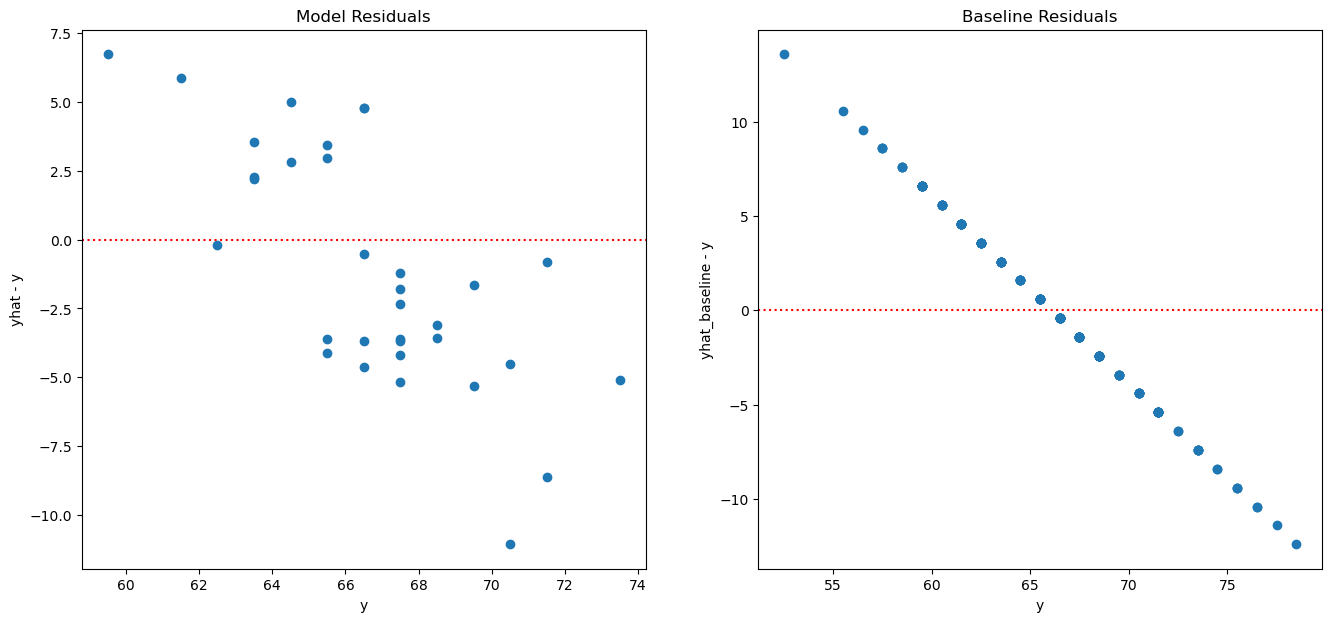

In [59]:
# I'm curious about the y_test plot
ev.plot_residuals(y_test, pd.Series(y_pred_test))

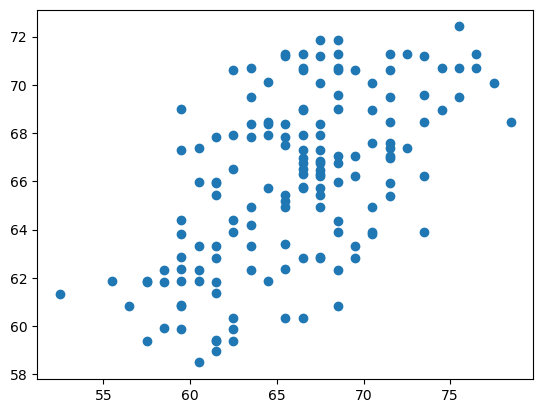

In [63]:
plt.scatter(y_test, pd.Series(y_pred_test))
plt.show()